In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import abspath, join, pardir

from nilearn import datasets
# from roi_mean_sub import roi_mean_interface
from bids.layout import BIDSLayout
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.io import DataSink, DataGrabber
from nipype.algorithms.confounds import TSNR
from nipype.interfaces.utility import Function, IdentityInterface
from nilearn.input_data import NiftiLabelsMasker
from nipype.interfaces import fsl
from nipype.interfaces.utility import Rename
from nilearn import image, plotting, signal
import nibabel as nib

import networkx as nx

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

/home/connoi/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
df = pd.read_csv("~/Downloads/Nabarun/fmriprep_list", header=None)
df.head()

0
0  00709354_04
1  00807897_04
2  01841461_02
3  01841461_04
4  02158395_00

In [3]:
subs_join=""
for s in df[0]:
    subs_join+=s+","
print(subs_join)

00709354_04,00807897_04,01841461_02,01841461_04,02158395_00,02695917_04,02950975_02,03060782_01,03227207_10,03902977_11,04319814_02,04319814_04,46433373_02,46516939_10,46516939_12,46808242_09,46957588_04,48331728_02,48451825_10,49094578_04,


In [4]:
# !scp -r ~/RADC/sym_radc/fmriprep/{00709354_04,00807897_04,01841461_02,01841461_04,02158395_00,02695917_04,02950975_02,03060782_01,03227207_10,03902977_11,04319814_02,04319814_04,46433373_02,46516939_10,46516939_12,46808242_09,46957588_04,48331728_02,48451825_10,49094578_0} connoi@10.36.17.187:~/Downloads/Nabarun/RADC/fmriprep

In [5]:
%cd ~/Downloads/Nabarun/RADC/fmriprep

/home/connoi/Downloads/Nabarun/RADC/fmriprep


In [6]:
!ls

 00709354_04   02158395_00   03227207_10   46433373_02	 46957588_04	'~'
 00807897_04   02695917_04   03902977_11   46516939_10	 48331728_02
 01841461_02   02950975_02   04319814_02   46516939_12	 48451825_10
 01841461_04   03060782_01   04319814_04   46808242_09	 nilearn_cache


In [7]:
# !ls /4tb/nabarun/RADC/fmriprep2

In [8]:
# !ls /home/nabarun/RADC/fmriprep

In [44]:
layout = BIDSLayout('00709354_04',validate=False)
subjects = layout.get_subjects()
len(subjects)

1

In [10]:
# import os

# def absoluteFilePaths(directory, ext=".txt"):
#     lis = []
#     for dirpath,_,filenames in os.walk(directory):
#         for f in filenames:
#             if f.endswith(ext):
#                 lis.append(os.path.abspath(os.path.join(dirpath, f)))
#     lis.sort()
#     return lis

In [11]:
# func = absoluteFilePaths('~/Downloads/Nabarun/RADC/fmriprep', ".nii.gz")
# func

In [12]:
# confounds = absoluteFilePaths('/home/nabarun/RADC/fmriprep', ".tsv")
# confounds[0]

In [13]:
# np.shape(func), np.shape(confounds)

# Cleaning Confounders

In [69]:
!ls 00709354_04/fmriprep/sub-00709354/func

sub-00709354_task-rest_desc-confounds_timeseries.json
sub-00709354_task-rest_desc-confounds_timeseries.tsv
sub-00709354_task-rest_from-T1w_to-scanner_mode-image_xfm.txt
sub-00709354_task-rest_from-scanner_to-T1w_mode-image_xfm.txt
sub-00709354_task-rest_space-MNI152NLin6Asym_res-2_boldref.nii.gz
sub-00709354_task-rest_space-MNI152NLin6Asym_res-2_desc-brain_mask.json
sub-00709354_task-rest_space-MNI152NLin6Asym_res-2_desc-brain_mask.nii.gz
sub-00709354_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.json
sub-00709354_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz


In [70]:
import os
#Load functional data, confounds and mask
func_dir = '00709354_04/fmriprep/sub-00709354/func'
func = os.path.join(func_dir, 'sub-00709354_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz')
confound = os.path.join(func_dir, 'sub-00709354_task-rest_desc-confounds_timeseries.tsv')
mask = os.path.join(func_dir,'sub-00709354_task-rest_space-MNI152NLin6Asym_res-2_desc-brain_mask.nii.gz')

#Delimiter is \t --> tsv is a tab-separated spreadsheet
confound_df = pd.read_csv(confound, delimiter='\t')
confound_df.head()

global_signal  global_signal_derivative1  global_signal_power2  \
0     781.880236                        NaN         611336.704108   
1     782.050459                   0.170223         611602.920722   
2     780.816107                  -1.234352         609673.792928   
3     781.010453                   0.194346         609977.326995   
4     779.530227                  -1.480226         607667.374816   

   global_signal_derivative1_power2          csf  csf_derivative1  \
0                               NaN  1252.175083              NaN   
1                          0.028976  1249.156305        -3.018778   
2                          1.523625  1246.448501        -2.707804   
3                          0.037770  1247.471006         1.022505   
4                          2.191068  1246.304451        -1.166554   

   csf_derivative1_power2    csf_power2  white_matter  \
0                     NaN  1.567942e+06    755.735715   
1                9.113022  1.560391e+06    756.719236   
2                7.332200  1.553634e+06    756.429254   
3                1.045516  1.556184e+06    756.731921   
4                1.360849  1.553275e+06    755.819642   

   white_matter_derivative1  ...     rot_y  rot_y_derivative1  \
0                       NaN  ... -0.002272                NaN   
1                  0.983521  ... -0.001630           0.000643   
2                 -0.289982  ... -0.001282           0.000348   
3                  0.302667  ... -0.001254           0.000028   
4                 -0.912279  ... -0.001315          -0.000061   

   rot_y_derivative1_power2  rot_y_power2     rot_z  rot_z_derivative1  \
0                       NaN      0.000005  0.000330                NaN   
1              4.128191e-07      0.000003  0.001425           0.001096   
2              1.208327e-07      0.000002  0.001425           0.000000   
3              8.048569e-10      0.000002  0.000981          -0.000445   
4              3.769960e-09      0.000002  0.000731          -0.000249   

   rot_z_power2  rot_z_derivative1_power2  motion_outlier00  motion_outlier01  
0  1.085768e-07                       NaN               0.0               0.0  
1  2.031623e-06              1.200865e-06               0.0               0.0  
2  2.031623e-06              0.000000e+00               0.0               0.0  
3  9.615607e-07              1.978097e-07               0.0               0.0  
4  5.349503e-07              6.209516e-08               0.0               0.0  

[5 rows x 141 columns]

In [71]:
confound_vars = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z','global_signal','a_comp_cor_01','a_comp_cor_02']
confound_df = confound_df[confound_vars]
confound_df.head()

trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  global_signal  \
0  0.031064 -0.046671 -0.008853 -0.001685 -0.002272  0.000330     781.880236   
1  0.096079 -0.062328 -0.063428 -0.001065 -0.001630  0.001425     782.050459   
2  0.083491 -0.062336 -0.028655 -0.001137 -0.001282  0.001425     780.816107   
3  0.056827 -0.018143 -0.036945 -0.001137 -0.001254  0.000981     781.010453   
4  0.052992 -0.020973 -0.036947 -0.000565 -0.001315  0.000731     779.530227   

   a_comp_cor_01  a_comp_cor_02  
0      -0.008859       0.071996  
1       0.085065      -0.058462  
2       0.045094      -0.036054  
3      -0.005330      -0.055941  
4       0.059362       0.017797

In [72]:
for col in confound_df.columns:

    #Example X --> X_dt
    new_name = '{}_dt'.format(col)

    #Compute differences for each pair of rows from start to end.
    new_col = confound_df[col].diff()

    #Make new column in our dataframe
    confound_df[new_name] = new_col

confound_df.head()

trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  global_signal  \
0  0.031064 -0.046671 -0.008853 -0.001685 -0.002272  0.000330     781.880236   
1  0.096079 -0.062328 -0.063428 -0.001065 -0.001630  0.001425     782.050459   
2  0.083491 -0.062336 -0.028655 -0.001137 -0.001282  0.001425     780.816107   
3  0.056827 -0.018143 -0.036945 -0.001137 -0.001254  0.000981     781.010453   
4  0.052992 -0.020973 -0.036947 -0.000565 -0.001315  0.000731     779.530227   

   a_comp_cor_01  a_comp_cor_02  trans_x_dt  trans_y_dt  trans_z_dt  rot_x_dt  \
0      -0.008859       0.071996         NaN         NaN         NaN       NaN   
1       0.085065      -0.058462    0.065015   -0.015657   -0.054574  0.000619   
2       0.045094      -0.036054   -0.012588   -0.000008    0.034773 -0.000072   
3      -0.005330      -0.055941   -0.026664    0.044193   -0.008290  0.000000   
4       0.059362       0.017797   -0.003834   -0.002830   -0.000002  0.000572   

   rot_y_dt  rot_z_dt  global_signal_dt  a_comp_cor_01_dt  a_comp_cor_02_dt  
0       NaN       NaN               NaN               NaN               NaN  
1  0.000643  0.001096          0.170223          0.093923         -0.130458  
2  0.000348  0.000000         -1.234352         -0.039970          0.022407  
3  0.000028 -0.000445          0.194346         -0.050424         -0.019887  
4 -0.000061 -0.000249         -1.480226          0.064692          0.073738

In [73]:
#First we'll load in our data and check the shape
raw_func_img = image.load_img(func)
raw_func_img.shape

(91, 109, 91, 160)

In [74]:
#Get all timepoints after the 4th
func_img = raw_func_img.slicer[:,:,:,5:]
func_img.shape

#Drop confound dummy TRs from the dataframe to match the size of our new func_img
drop_confound_df = confound_df.loc[5:]
print(drop_confound_df.shape) #number of rows should match that of the functional image
drop_confound_df.head()

(155, 18)


trans_x   trans_y   trans_z     rot_x     rot_y     rot_z  global_signal  \
5  0.047603 -0.028861 -0.018678 -0.000789 -0.001169  0.000731     777.089903   
6  0.066157  0.025649 -0.058076 -0.000609 -0.000986  0.000731     778.639086   
7  0.051989 -0.009766 -0.036854 -0.000565 -0.001036  0.001001     777.337001   
8  0.060675 -0.028470 -0.032054 -0.000122 -0.000986  0.001037     777.148341   
9  0.050210  0.041505 -0.079700 -0.000130 -0.001111  0.000852     778.790472   

   a_comp_cor_01  a_comp_cor_02  trans_x_dt  trans_y_dt  trans_z_dt  rot_x_dt  \
5      -0.000017      -0.014911   -0.005389   -0.007888    0.018269 -0.000224   
6      -0.026468      -0.103121    0.018554    0.054510   -0.039398  0.000180   
7      -0.104305      -0.029324   -0.014168   -0.035415    0.021223  0.000044   
8      -0.040219      -0.000346    0.008686   -0.018704    0.004799  0.000443   
9       0.036536      -0.068117   -0.010464    0.069975   -0.047646 -0.000008   

   rot_y_dt      rot_z_dt  global_signal_dt  a_comp_cor_01_dt  \
5  0.000147 -1.000000e-09         -2.440324         -0.059379   
6  0.000183  1.000000e-09          1.549183         -0.026451   
7 -0.000051  2.695470e-04         -1.302085         -0.077837   
8  0.000051  3.648000e-05         -0.188660          0.064087   
9 -0.000125 -1.852400e-04          1.642131          0.076755   

   a_comp_cor_02_dt  
5         -0.032708  
6         -0.088210  
7          0.073796  
8          0.028978  
9         -0.067771

In [75]:
confounds_matrix = drop_confound_df.values

#Confirm matrix size is correct
confounds_matrix.shape

(155, 18)

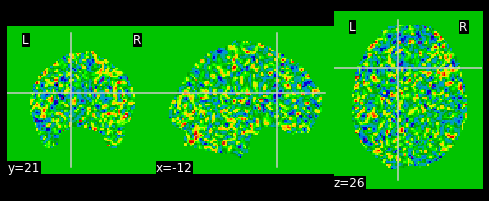

In [76]:
#Set some constants
high_pass= 0.009
low_pass = 0.08
t_r = 2

#Clean!
clean_img = image.clean_img(func_img,confounds=confounds_matrix,detrend=True,standardize=True,
                         low_pass=low_pass,high_pass=high_pass,t_r=t_r, mask_img=mask)

#Let's visualize our result! Doesn't really tell us much, but that's the data we're using for analysis!
plotting.plot_epi(clean_img.slicer[:,:,:,50])

# Parcellations

In [77]:
 layout.get_tasks()

['rest']

In [89]:
parcel_dir = '/home/connoi/Downloads/Nabarun/RADC/rois'
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(parcel_dir)

In [90]:
!ls ~/Downloads/Nabarun/RADC/rois/

yeo_2011


In [80]:
# dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
# atlas_harvard_oxford = dataset.maps

# print('Atlas ROIs are located in nifti image (4D) at: %s' %
#       atlas_harvard_oxford)  # 4D data

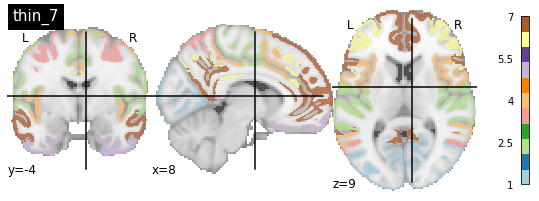

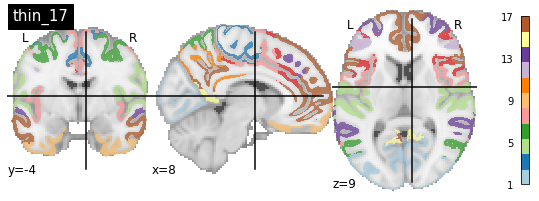

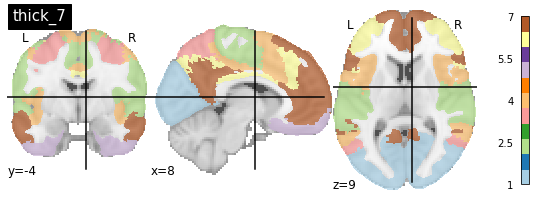

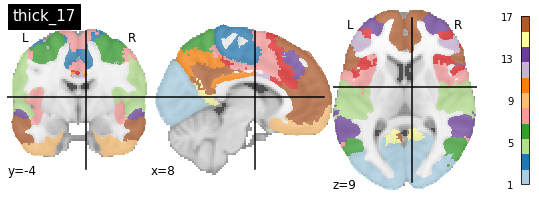

In [91]:
#Define where to slice the image
cut_coords=(8, -4, 9)
#Show a colorbar
colorbar=True
#Color scheme to show when viewing image
cmap='Paired'

#Plot all parcellation schemas referred to by atlas_yeo_2011
plotting.plot_roi(atlas_yeo_2011['thin_7'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thin_7')
plotting.plot_roi(atlas_yeo_2011['thin_17'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thin_17')
plotting.plot_roi(atlas_yeo_2011['thick_7'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thick_7')
plotting.plot_roi(atlas_yeo_2011['thick_17'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thick_17')

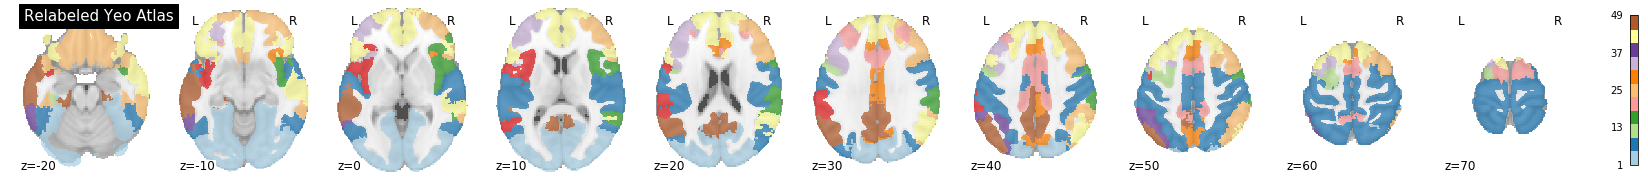

In [92]:
from nilearn.regions import connected_label_regions
atlas_yeo=atlas_yeo_2011['thick_7']
region_labels = connected_label_regions(atlas_yeo)
plotting.plot_roi(region_labels,
            cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
            display_mode='z',
            colorbar=True,
            cmap='Paired',
            title='Relabeled Yeo Atlas')

In [93]:
# region_labels.to_filename('/4tb/nabarun/RADC/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz')

In [96]:
# func_dir = '/4tb/nabarun/RADC/fmriprep/02158395_00/fmriprep/sub-02158395/func'
# func_file = os.path.join(func_dir, 'sub-02158395_task-rest_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz')
func_img = nib.load(func)
print('Size of functional file:', func_img.shape)
print('Size of atlas file:', region_labels.shape)

Size of functional file: (91, 109, 91, 160)
Size of atlas file: (256, 256, 256)


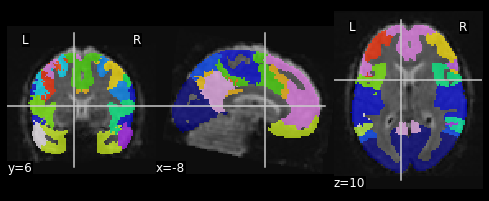

In [97]:
resampled_atlas = image.resample_to_img(region_labels, func_img, interpolation = 'nearest')
plotting.plot_roi(resampled_atlas, func_img.slicer[:,:,:,54])

In [98]:
resampled_atlas.shape

(91, 109, 91)

## Visualizing ROIs

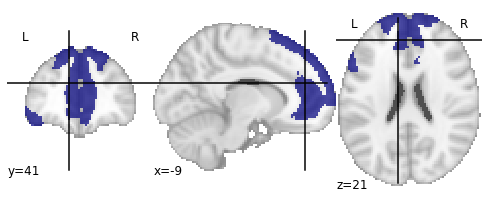

In [99]:
roi = 44
roi_mask = image.math_img('a == {}'.format(roi), a=resampled_atlas)
masked_resamp_yeo = image.math_img('a*b',a=resampled_atlas,b=roi_mask)
plotting.plot_roi(masked_resamp_yeo)

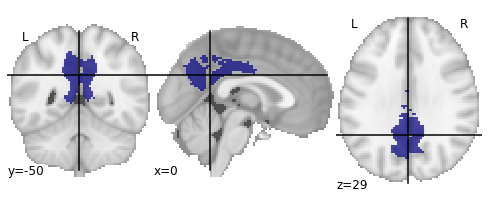

In [100]:
roi = 46
roi_mask = image.math_img('a == {}'.format(roi), a=resampled_atlas)
masked_resamp_yeo = image.math_img('a*b',a=resampled_atlas,b=roi_mask)
plotting.plot_roi(masked_resamp_yeo)

# Functional Connectivity Analysis

In [101]:
# layout = BIDSLayout('/4tb/nabarun/RADC/fmriprep2/',validate=False)
# subjects = layout.get_subjects()

In [102]:
len(subjects)

16

In [103]:
# parcel_file = '/4tb/nabarun/RADC/rois/yeo_2011/Yeo_JNeurophysiol11_MNI152/relabeled_yeo_atlas.nii.gz'
# yeo_7 = image.load_img(parcel_file)

In [104]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
print('MSDL has {0} ROIs, part of the following networks :\n{1}.'.format(
    n_regions, msdl_data.networks))


Dataset created in /home/connoi/nilearn_data/msdl_atlas

MSDL has 39 ROIs, part of the following networks :
[b'Aud', b'Aud', b'Striate', b'DMN', b'DMN', b'DMN', b'DMN', b'Occ post', b'Motor', b'R V Att', b'R V Att', b'R V Att', b'R V Att', b'Basal', b'L V Att', b'L V Att', b'L V Att', b'D Att', b'D Att', b'Vis Sec', b'Vis Sec', b'Vis Sec', b'Salience', b'Salience', b'Salience', b'Temporal', b'Temporal', b'Language', b'Language', b'Language', b'Language', b'Language', b'Cereb', b'Dors PCC', b'Cing-Ins', b'Cing-Ins', b'Cing-Ins', b'Ant IPS', b'Ant IPS'].


 ...done. (3 seconds, 0 min)
Extracting data from /home/connoi/nilearn_data/msdl_atlas/8eaecb9e05c478f565847000d9902a25/MSDL_rois.zip..... done.


In [105]:
from nilearn import input_data

# masker = input_data.NiftiLabelsMasker(labels_img=yeo_7,
#                                       standardize=True,
#                                       memory='nilearn_cache',
#                                       verbose=1,
#                                       detrend=True,
#                                      low_pass = 0.08,
#                                      high_pass = 0.009,
#                                      t_r=2)
masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)

In [18]:
def collect_data(layout, participant_label, bids_validate=True):
    queries = {
        "func": {"datatype": "func", "suffix": "bold"},
        "confounds": {"datatype": "func", "suffix": ['timeseries','regressors']},
        "flair": {"datatype": "anat", "suffix": "FLAIR"},
        "t2w": {"datatype": "anat", "suffix": "T2w"},
        "t1w": {"datatype": "anat", "suffix": "T1w"},
        "roi": {"datatype": "anat", "suffix": "roi"},
    }

    subj_data = {
        dtype: sorted(
            layout.get(
                return_type="file",
                subject=participant_label,
                extension=["nii", "nii.gz", "tsv"],
                **query
            )
        )
        for dtype, query in queries.items()
    }

    return subj_data

In [19]:
# for sub in subjects:
    #Get functional file and confounds file
#     print(sub)
#     subj_data = collect_data(layout, sub, False)

In [32]:
def extract_confounds(confound_file, confound_vars):
    confound_df = pd.read_csv(confound_file, delimiter='\t')
    confound_df = confound_df[confound_vars]
    for col in confound_df.columns:

        #Example X --> X_dt
        new_name = '{}_dt'.format(col)

        #Compute differences for each pair of rows from start to end.
        new_col = confound_df[col].diff()

        #Make new column in our dataframe
        confound_df[new_name] = new_col
    return confound_df.values

In [125]:
pooled_subjects = []
ctrl_subjects = []
schz_subjects = []
tr_drop = 4

for sub in subjects:
    #Get functional file and confounds file
    subj_data = collect_data(layout, sub, False)
    func_file = subj_data['func'][0]
    confound_file = subj_data['confounds'][0]

    #Load functional file and perform TR drop
    func_img = image.load_img(func_file)
    func_img = func_img.slicer[:,:,:,tr_drop+1:]

    #Convert cnfounds file into required format
    confound_vars = ['trans_x', 'trans_y', 'trans_z', 
                     'rot_x', 'rot_y', 'rot_z',
                     'global_signal','a_comp_cor_01','a_comp_cor_02']
    confounds = extract_confounds(confound_file, confound_vars)

    #Drop TR on confound matrix
    confounds = confounds[tr_drop+1:,:]

    #Apply cleaning, parcellation and extraction to functional data
    time_series = masker.fit_transform(func_img,confounds)
    pooled_subjects.append(time_series)

In [126]:
!mkdir -p /home/connoi/Downloads/Nabarun/RADC/pooled_subjects
np.save('/home/connoi/Downloads/Nabarun/RADC/pooled_subjects', pooled_subjects)
# pooled_subjects = np.load('/4tb/nabarun/RADC/pooled_subjects.npy')

mkdir: cannot create directory ‘/home/connoi/Downloads/Nabarun/RADC/pooled_subjects’: File exists


In [128]:
np.shape(pooled_subjects)

(16, 155, 39)

In [129]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

# ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
# schz_correlation_matrices = correlation_measure.fit_transform(schz_subjects)
pooled_correlation_matrices = correlation_measure.fit_transform(pooled_subjects)

In [130]:
np.save('/home/connoi/Downloads/Nabarun/RADC/pooled_correlation_matrices', pooled_correlation_matrices)

In [39]:
def plot_matrices(matrices, matrix_kind):
    n_matrices = len(matrices)
    fig = plt.figure(figsize=(n_matrices * 4, 4))
    for n_subject, matrix in enumerate(matrices):
        plt.subplot(1, n_matrices, n_subject + 1)
        matrix = matrix.copy()  # avoid side effects
        # Set diagonal to zero, for better visualization
        np.fill_diagonal(matrix, 0)
        vmax = np.max(np.abs(matrix))
        title = '{0}, subject {1}'.format(matrix_kind, n_subject)
        plotting.plot_matrix(matrix, vmin=-vmax, vmax=vmax, cmap='RdBu_r',
                             title=title, figure=fig, colorbar=False)

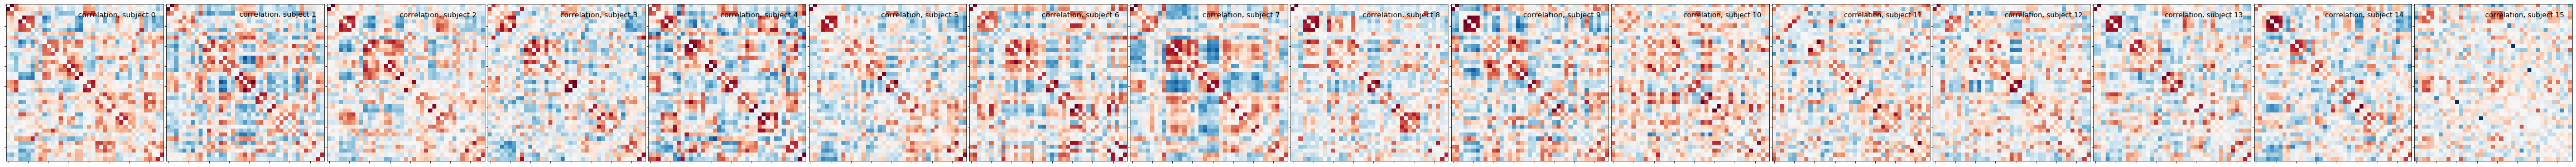

In [132]:
plot_matrices(pooled_correlation_matrices, 'correlation')

In [133]:
pooled_correlation_matrices.shape

(16, 39, 39)

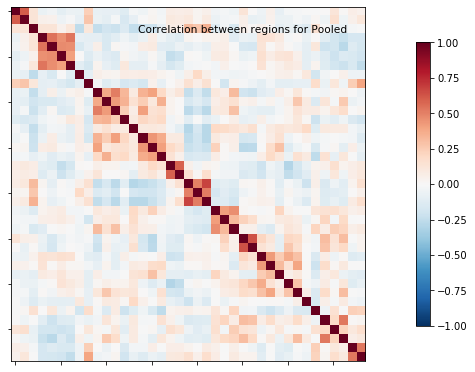

In [134]:
#Getting the mean correlation matrix across all treatment subjects
mean_correlation_matrix = correlation_measure.mean_

#Visualizing the mean correlation
plotting.plot_matrix(mean_correlation_matrix, vmax=1, vmin=-1,
                               colorbar=True, title='Correlation between regions for Pooled')

In [135]:
np.shape(msdl_coords)

(39, 3)

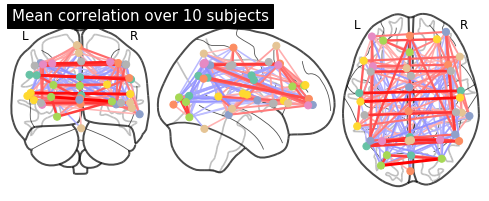

In [136]:
#Getting the center coordinates from the component decomposition to use as atlas labels
# coords = plotting.find_probabilistic_atlas_cut_coords(atlas_yeo)
plotting.plot_connectome(mean_correlation_matrix, msdl_coords,
                         edge_threshold="80%",
                         title='Mean correlation over 10 subjects')

### Schaefer atlas

In [16]:
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=1000, yeo_networks=7, 
                               resolution_mm=1)
atlas_filename = dataset.maps
labels = dataset.labels

 ...done. (0 seconds, 0 min)


 ...done. (1 seconds, 0 min)


In [22]:
# data = datasets.fetch_development_fmri(n_subjects=1)
fmri_filenames = subj_data['func'][0]

from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,
                           memory='nilearn_cache', verbose=0)

time_series = masker.fit_transform(fmri_filenames)

[NiftiLabelsMasker.fit_transform] loading data from /home/connoi/nilearn_data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/connoi/Downloads/Nabarun/RADC/fmriprep/48451825_10/fmriprep/sub-48451825/func/sub-48451825_task-rest_space-MNI152NLin6Asym_res-2_desc-preproc_bold.nii.gz', 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels_img': '/home/connoi/nilearn_data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(loc

In [33]:
pooled_subjects = []
ctrl_subjects = []
schz_subjects = []
tr_drop = 4

for sub in subjects:
    #Get functional file and confounds file
    subj_data = collect_data(layout, sub, False)
    func_file = subj_data['func'][0]
    confound_file = subj_data['confounds'][0]

    #Load functional file and perform TR drop
    func_img = image.load_img(func_file)
    func_img = func_img.slicer[:,:,:,tr_drop+1:]

    #Convert cnfounds file into required format
    confound_vars = ['trans_x', 'trans_y', 'trans_z', 
                     'rot_x', 'rot_y', 'rot_z',
                     'global_signal','a_comp_cor_01','a_comp_cor_02']
    confounds = extract_confounds(confound_file, confound_vars)

    #Drop TR on confound matrix
    confounds = confounds[tr_drop+1:,:]

    #Apply cleaning, parcellation and extraction to functional data
    time_series = masker.fit_transform(func_img,confounds)
    pooled_subjects.append(time_series)

[NiftiLabelsMasker.fit_transform] loading data from /home/connoi/nilearn_data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f2a981bbbe0>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f2a54516880>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels_img': '/home/connoi/nilearn_data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=[ array([[ 0.047603, ..., -0.032708],
       ...,
       [ 0.121185, ..., -

[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
_______________________________________________filter_and_extract - 9.0s, 0.1min
[NiftiLabelsMasker.fit_transform] loading data from /home/connoi/nilearn_data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f2aa9106e80>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f2a980940d0>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels_img': '/home/connoi/nilearn_data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',


[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
_______________________________________________filter_and_extract - 8.9s, 0.1min
[NiftiLabelsMasker.fit_transform] loading data from /home/connoi/nilearn_data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7f2a54516910>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7f2a54516880>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'labels_img': '/home/connoi/nilearn_data/schaefer_2018/Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_1mm.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',


In [36]:
!mkdir -p /home/connoi/Downloads/Nabarun/RADC/schaefer_pooled_subjects
np.save('/home/connoi/Downloads/Nabarun/RADC/schaefer_pooled_subjects', pooled_subjects)
# pooled_subjects = np.load('/4tb/nabarun/RADC/pooled_subjects.npy')

In [35]:
np.shape(pooled_subjects)

(16, 155, 1000)

In [37]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')

# ctrl_correlation_matrices = correlation_measure.fit_transform(ctrl_subjects)
# schz_correlation_matrices = correlation_measure.fit_transform(schz_subjects)
pooled_correlation_matrices = correlation_measure.fit_transform(pooled_subjects)

In [38]:
np.save('/home/connoi/Downloads/Nabarun/RADC/schaefer_pooled_correlation_matrices', pooled_correlation_matrices)

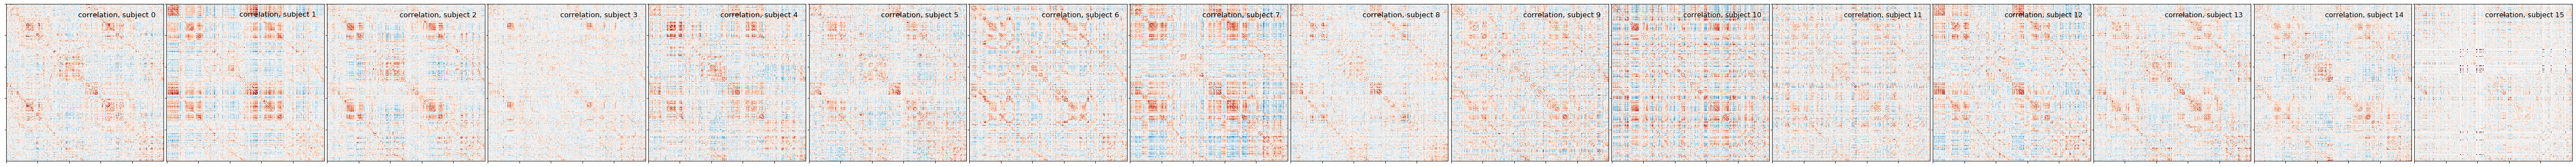

In [40]:
plot_matrices(pooled_correlation_matrices, 'correlation')

# Sequential

In [12]:
df = pd.read_csv('~/RADC/dataset_611_basic.csv')
df.head(5)

sub_id     age_bl  msex
0  2158395  85.902806     0
1  3918123  87.885010     0
2  6131380  78.795346     0
3  6702361  82.146475     0
4  8098966  72.158795     0

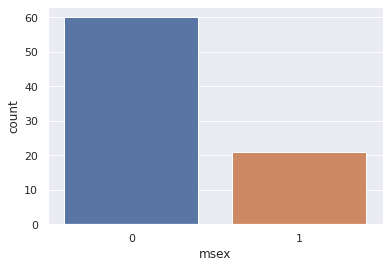

In [16]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="msex", data=df)

In [17]:
pooled_correlation_matrices = np.load('/4tb/nabarun/RADC/pooled_correlation_matrices_19nov.npy')

In [18]:
pooled_correlation_matrices.shape

(81, 39, 39)

In [21]:
#Splitting data into training and testing

from sklearn.model_selection import train_test_split
y = df['msex']
X_train, X_test, y_train, y_test = train_test_split(pooled_correlation_matrices, y, test_size=0.2, stratify=y)

In [22]:
X_train.shape, y_train.shape

((64, 39, 39), (64,))

In [23]:
#Creating the classification model
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(64, activation='tanh', kernel_initializer='random_normal', input_shape=pooled_correlation_matrices.shape[1:]))
#Second  Hidden Layer
classifier.add(Dense(32, activation='relu', kernel_initializer='random_normal'))
#Third  Hidden Layer
classifier.add(Dense(16, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Flatten())
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

Using TensorFlow backend.


In [24]:
#Compiling the model
classifier.compile(optimizer = Adam(lr =.0001),loss='binary_crossentropy', metrics =['accuracy'])
classifier.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 39, 64)            2560      
_________________________________________________________________
dense_2 (Dense)              (None, 39, 32)            2080      
_________________________________________________________________
dense_3 (Dense)              (None, 39, 16)            528       
_________________________________________________________________
flatten_1 (Flatten)          (None, 624)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 625       
Total params: 5,793
Trainable params: 5,793
Non-trainable params: 0
_________________________________________________________________


In [25]:
classifier.fit(np.array(X_train),np.array(y_train), epochs=100)


Epoch 1/100
64/64 [==============================] - 1s 9ms/step - loss: 0.6928 - accuracy: 0.5781
Epoch 2/100
64/64 [==============================] - 0s 210us/step - loss: 0.6922 - accuracy: 0.6250
Epoch 3/100
64/64 [==============================] - 0s 317us/step - loss: 0.6916 - accuracy: 0.7500
Epoch 4/100
64/64 [==============================] - 0s 228us/step - loss: 0.6911 - accuracy: 0.7344
Epoch 5/100
64/64 [==============================] - 0s 266us/step - loss: 0.6906 - accuracy: 0.7344
Epoch 6/100
64/64 [==============================] - 0s 351us/step - loss: 0.6900 - accuracy: 0.7344
Epoch 7/100
64/64 [==============================] - 0s 425us/step - loss: 0.6894 - accuracy: 0.7344
Epoch 8/100
64/64 [==============================] - 0s 236us/step - loss: 0.6888 - accuracy: 0.7344
Epoch 9/100
64/64 [==============================] - 0s 263us/step - loss: 0.6883 - accuracy: 0.7344
Epoch 10/100
64/64 [==============================] - 0s 183us/step - loss: 0.6877 - accurac

In [26]:
eval_model=classifier.evaluate(np.array(X_train), np.array(y_train))
eval_model

64/64 [==============================] - 0s 3ms/step


[0.5680362582206726, 0.734375]

In [27]:
#Making the classification and determining accuracy
y_pred=classifier.predict(X_test,batch_size=32)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred)
print(cm)
cr = classification_report(y_test, y_pred)
print(cr)

[[13  0]
 [ 4  0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       0.00      0.00      0.00         4

    accuracy                           0.76        17
   macro avg       0.38      0.50      0.43        17
weighted avg       0.58      0.76      0.66        17



# Keras CNN

In [28]:
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
# Model / data parameters
num_classes = 2
input_shape = (39, 39, 1)

# Make sure images have shape (39, 39, 1)
x_train = np.expand_dims(X_train, -1)
x_test = np.expand_dims(X_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (64, 39, 39, 1)
64 train samples
17 test samples


In [30]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(48, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 37, 37, 48)        480       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        27712     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
____

In [31]:
batch_size = 1
epochs = 15

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 57 samples, validate on 7 samples
Epoch 1/15
57/57 [==============================] - 1s 26ms/sample - loss: 0.6262 - acc: 0.6316 - val_loss: 0.4077 - val_acc: 0.8571
Epoch 2/15
57/57 [==============================] - 0s 8ms/sample - loss: 0.6474 - acc: 0.7193 - val_loss: 0.5303 - val_acc: 0.8571
Epoch 3/15
57/57 [==============================] - 0s 7ms/sample - loss: 0.6115 - acc: 0.7193 - val_loss: 0.5246 - val_acc: 0.8571
Epoch 4/15
57/57 [==============================] - 1s 9ms/sample - loss: 0.5689 - acc: 0.7193 - val_loss: 0.4286 - val_acc: 0.8571
Epoch 5/15
57/57 [==============================] - 0s 8ms/sample - loss: 0.5790 - acc: 0.7193 - val_loss: 0.5024 - val_acc: 0.8571
Epoch 6/15
57/57 [==============================] - 0s 9ms/sample - loss: 0.5423 - acc: 0.7193 - val_loss: 0.4974 - val_acc: 0.8571
Epoch 7/15
57/57 [==============================] - 0s 8ms/sample - loss: 0.4875 - acc: 0.8246 - val_loss: 0.4529 - val_acc: 0.8571
Epoch 8/15
57/57 [==============

In [32]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6271137595176697
Test accuracy: 0.7647059


In [40]:
#Making the classification and determining accuracy
y_pred=model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)
cr = classification_report(np.argmax(y_test, axis=1), y_pred)
print(cr)

[[13  0]
 [ 4  0]]
              precision    recall  f1-score   support

           0       0.76      1.00      0.87        13
           1       0.00      0.00      0.00         4

    accuracy                           0.76        17
   macro avg       0.38      0.50      0.43        17
weighted avg       0.58      0.76      0.66        17



# GCN

In [21]:
!ls /4tb/nabarun/RADC/

fmriprep			 pooled_correlation_matrices_19nov.npy	rois
fmriprep2			 pooled_subjects.npy
pooled_correlation_matrices.npy  pooled_subjects_19nov.npy


In [22]:
pooled_correlation_matrices = np.load('/4tb/nabarun/RADC/pooled_correlation_matrices_19nov.npy')

      var1  var2     value
0        0     0  1.000000
1        0     1  0.799843
2        0     2 -0.012281
3        0     3  0.219004
4        0     4  0.148490
...    ...   ...       ...
1516    38    34 -0.053915
1517    38    35 -0.169891
1518    38    36  0.091689
1519    38    37  0.765107
1520    38    38  1.000000

[1521 rows x 3 columns]
      var1  var2     value
0        0     0  1.000000
1        0     1  0.799843
3        0     3  0.219004
7        0     7  0.211233
23       0    23  0.342932
...    ...   ...       ...
1501    38    19  0.336904
1502    38    20  0.302065
1503    38    21  0.307885
1519    38    37  0.765107
1520    38    38  1.000000

[371 rows x 3 columns]


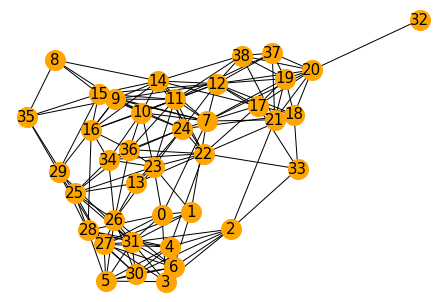

In [35]:
import networkx as nx

corr = pd.DataFrame(pooled_correlation_matrices[1])
# Transform it in a links data frame (3 columns only):
links = corr.stack().reset_index()
links.columns = ['var1', 'var2','value']
print(links)
 
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['value'] > 0.2)]
# links_filtered=links.loc[ (links['value'] > 0.4) & (links['var1'] != links['var2']) ]
print(links_filtered)
 
# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr='value')
 
# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

In [26]:
graphs = []

for corr in pooled_correlation_matrices:
    corr = pd.DataFrame(corr)
    # Transform it in a links data frame (3 columns only):
    links = corr.stack().reset_index()
    links.columns = ['var1', 'var2','value']

    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    links_filtered=links.loc[ (links['value'] > 0.1)]
    # links_filtered=links.loc[ (links['value'] > 0.4) & (links['var1'] != links['var2']) ]

    # Build your graph
    G=nx.from_pandas_edgelist(links_filtered, 'var1', 'var2', edge_attr='value')
    
    graphs.append(G)

    # Plot the network:
    # nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)
print("Completed", len(pooled_correlation_matrices), "matrices to graph.")

Completed 81 matrices to graph.


In [30]:
from keras.layers import MaxPooling2D, Reshape
from spektral.layers import GraphConv, ChebConv
from spektral.utils import localpooling_filter

Using TensorFlow backend.


In [31]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 0.03  # Learning rate for SGD
batch_size = 1       # Batch size
epochs = 20         # Number of training epochs

def GCN_single_layer(A, N=39*39, F=1,
                     n_out=2,
                     l2_reg=l2_reg, 
                     learning_rate=learning_rate,
                    ):
    # Computes a normalized Laplacian (as the conv filter)
    L = localpooling_filter(A)
    
    # Model definition
    # N: Number of nodes in the graphs
    # F: Node features dimensionality
    X_in = Input(shape=(N, F))
    # Pass A as a fixed tensor, otherwise Keras will complain about inputs of
    # different rank.
    A_in = Input(tensor=sp_matrix_to_sp_tensor(L))

    graph_conv = GraphConv(10,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])

    fc = Flatten()(graph_conv)
    output = Dense(n_out, activation='softmax')(fc)
    
    # Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model


def GCN(A, N=39*39, F=1,
        n_out=2,
        l2_reg=l2_reg, 
        learning_rate=learning_rate,
       ):
    '''Build a graph convolution network given A.
    '''
    # Computes a normalized Laplacian (as the conv filter)
    L = localpooling_filter(A)
    
    # Model definition
    # N: Number of nodes in the graphs
    # F: Node features dimensionality
    X_in = Input(shape=(N, F))
    
    # Pass A as a fixed tensor, otherwise Keras will complain about inputs of
    # different rank.
    A_in = Input(tensor=sp_matrix_to_sp_tensor(L))

    graph_conv = GraphConv(32,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])
    graph_conv = GraphConv(32,
                           activation='relu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([graph_conv, A_in])
    
    rs = Reshape((28, 28, 32))(graph_conv)
    pooled = MaxPooling2D(pool_size=(2, 2))(rs)
    flatten = Flatten()(pooled)
    fc = Dense(512, activation='relu')(flatten)
    output = Dense(n_out, activation='softmax')(fc)
    
    # Build model
    model = Model(inputs=[X_in, A_in], outputs=output)
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model

In [32]:
test_scores = []

In [ ]:
print(A.nnz)
model_full_grid = GCN_single_layer(A)
model_full_grid.summary()

In [ ]:
# Train model
validation_data = (X_val, y_val)
model_full_grid.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    validation_split=0.1,
                    epochs=epochs)

In [15]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.datasets import mnist
from spektral.layers import GraphConv
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import batch_iterator

# Parameters
learning_rate = 1e-3  # Learning rate for Adam
batch_size = 32       # Batch size
epochs = 1000         # Number of training epochs
patience = 10         # Patience for early stopping
l2_reg = 5e-4         # Regularization rate for l2

# Load data
x_tr, y_tr, x_va, y_va, x_te, y_te, A = mnist.load_data()
x_tr, x_va, x_te = x_tr[..., None], x_va[..., None], x_te[..., None]
N = x_tr.shape[-2]    # Number of nodes in the graphs
F = x_tr.shape[-1]    # Node features dimensionality
n_out = 10            # Dimension of the target

# Create filter for GCN and convert to sparse tensor
fltr = GraphConv.preprocess(A)
fltr = sp_matrix_to_sp_tensor(fltr)

In [16]:
x_tr.shape, N, A.shape

((50000, 784, 1), 784, (784, 784))

In [29]:
A.nnz

6396

In [17]:
# Build model
class Net(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = GraphConv(32, activation='elu', kernel_regularizer=l2(l2_reg))
        self.conv2 = GraphConv(32, activation='elu', kernel_regularizer=l2(l2_reg))
        self.flatten = Flatten()
        self.fc1 = Dense(512, activation='relu')
        self.fc2 = Dense(n_out, activation='softmax')

    def call(self, inputs):
        x, fltr = inputs
        x = self.conv1([x, fltr])
        x = self.conv2([x, fltr])
        output = self.flatten(x)
        output = self.fc1(output)
        output = self.fc2(output)

        return output


model = Net()
optimizer = Adam(lr=learning_rate)
loss_fn = SparseCategoricalCrossentropy()
acc_fn = SparseCategoricalAccuracy()

In [18]:
# Training step
@tf.function
def train(x, y):
    with tf.GradientTape() as tape:
        predictions = model([x, fltr], training=True)
        loss = loss_fn(y, predictions)
        loss += sum(model.losses)
    acc = acc_fn(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc


# Evaluation step
@tf.function
def evaluate(x, y):
    predictions = model([x, fltr], training=False)
    loss = loss_fn(y, predictions)
    loss += sum(model.losses)
    acc = acc_fn(y, predictions)

    return loss, acc

In [19]:
# Setup training
best_val_loss = 99999
current_patience = patience
curent_batch = 0
batches_in_epoch = int(np.ceil(x_tr.shape[0] / batch_size))
batches_tr = batch_iterator([x_tr, y_tr], batch_size=batch_size, epochs=epochs)

In [20]:
# Training loop
results_tr = []
results_te = np.zeros(2)
for batch in batches_tr:
    curent_batch += 1

    # Training step
    l, a = train(*batch)
    results_tr.append((l, a))

    if curent_batch == batches_in_epoch:
        batches_va = batch_iterator([x_va, y_va], batch_size=batch_size)
        results_va = [evaluate(*batch) for batch in batches_va]
        results_va = np.array(results_va)
        loss_va, acc_va = results_va.mean(0)
        if loss_va < best_val_loss:
            best_val_loss = loss_va
            current_patience = patience
            # Test
            batches_te = batch_iterator([x_te, y_te], batch_size=batch_size)
            results_te = [evaluate(*batch) for batch in batches_te]
            results_te = np.array(results_te)
        else:
            current_patience -= 1
            if current_patience == 0:
                print('Early stopping')
                break

        # Print results
        results_tr = np.array(results_tr)
        print('Train loss: {:.4f}, acc: {:.4f} | '
              'Valid loss: {:.4f}, acc: {:.4f} | '
              'Test loss: {:.4f}, acc: {:.4f}'
              .format(*results_tr.mean(0),
                      *results_va.mean(0),
                      *results_te.mean(0)))

        # Reset epoch
        results_tr = []
        curent_batch = 0


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Train loss: 0.2490, acc: 0.8829 | Valid loss: 0.1506, acc: 0.9295 | Test loss: 0.1382, acc: 0.9338
Train loss: 0.1317, acc: 0.9418 | Valid loss: 0.1151, acc: 0.9472 | Test loss: 0.1122, acc: 0.9488


KeyboardInterrupt: 

In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

OSError: libcusparse.so.10: cannot open shared object file: No such file or directory

In [9]:
from cnn_graph.lib import models, graph, coarsening, utils

In [10]:
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

AttributeError: 'Graph' object has no attribute 'sum'

In [15]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 40
params['batch_size']     = 1
params['eval_frequency'] = 200

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
y = df['msex']
C = y.max() + 1
assert C == np.unique(y).size

# Architecture.
params['F']              = [32, 64]  # Number of graph convolutional filters.
params['K']              = [20, 20]  # Polynomial orders.
params['p']              = [4, 2]    # Pooling sizes.
params['M']              = [512, C]  # Output dimensionality of fully connected layers.

# Optimization.
n_train = len(y)
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

In [ ]:
model = models.cgcnn(L, **params)
accuracy, loss, t_step = model.fit(X_train, y_train, X_val, y_val)

In [ ]:
class MLGCN():
    
    def __init__(self, node_dim=2, graph_dim=[3,3], nb_classes=2, nmax=15, alpha=0.025):
        """
        Parameters of the model architecture
        
        """
        self.graph_dims = [node_dim] + graph_dim
        self.n_layers = len(graph_dim)
        self.nb_classes = nb_classes
        self.nmax = nmax
        self.alpha = alpha
        
        self.build_model()
        
    def build_model(self):
        self.adjs = tf.placeholder(tf.float32, shape=[None, self.nmax, self.nmax])
        self.targets = tf.placeholder(tf.float32, shape=[None, self.nb_classes])
        
        self.A = {i+1: tf.Variable(tf.random_normal([self.graph_dims[i+1], self.graph_dims[i]])) \
             for i in range(self.n_layers)}
        self.B = {i+1: tf.Variable(tf.random_normal([self.graph_dims[i+1], self.graph_dims[i]])) \
             for i in range(self.n_layers)}
        self.W  = tf.Variable(tf.random_normal([self.graph_dims[-1], self.nb_classes]))
        
        
        self.M, self.H, self.G = {}, {}, {}
        
        self.H[0] = tf.placeholder(tf.float32, shape=[None, self.nmax, self.graph_dims[0]])
        
        for i in range(1, self.n_layers+1):
        
            self.M[i] = tf.einsum('adc,adb->abc', self.H[i-1], self.adjs)
            self.H[i] = tf.nn.relu(tf.tensordot(self.M[i], self.A[i], (2, 1)) 
                                   + tf.tensordot(self.H[i-1], self.B[i], (2, 1)))
            self.G[i] = tf.reduce_mean(self.H[i], 1)
        
        Y_OUT = tf.matmul(self.G[self.n_layers], self.W)
        cost = tf.losses.softmax_cross_entropy(self.targets, Y_OUT)
        
        self.predictions = tf.argmax(Y_OUT, 1)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.alpha)
        self.train = optimizer.minimize(cost)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def fit(self, adj, embds, y, epochs=20, batch_size=10, shuffle=True):
        self.scores = []
        minibatches = ceil(len(adj) / batch_size)
        
        y_enc = one_hot_encode(y)
        
        j = 0
        for i in range(epochs):
            INDS = np.array(range(len(adj)))
            
            if shuffle:
                idx = np.random.permutation(y.shape[0]) 
                INDS = INDS[idx]
                
            mini = np.array_split(INDS, minibatches)
            
            for inds in mini:
                j+=1
                sys.stderr.write('\rEpoch: %d/%d' % (j, epochs*minibatches))
                sys.stderr.flush()
                self.sess.run(self.train, feed_dict={self.adjs:adj[inds], self.H[0]:embds[inds], 
                                                self.targets:y_enc[inds]})
                
            self.scores.append(self.score(adj, embds, y))
            
        
        
    def predict(self, adj, embds):
        return self.sess.run(self.predictions, feed_dict={self.adjs:adj, self.H[0]:embds})
    
    def score(self, adj, embds,y):
        y_ = self.predict(adj, embds)
        return 100*(y==y_).mean()